In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
images_path = '/content/drive/MyDrive/Classroom/data/images'
masks_path = '/content/drive/MyDrive/Classroom/data/labels'

In [8]:
pip install pylibtiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylibtiff: filename=pylibtiff-0.6.1-cp310-cp310-linux_x86_64.whl size=202896 sha256=a71453feb6258b2d7208c426f5f344b77e1ff586a69174c5e770d2291073d862
  Stored in directory: /root/.cache/pip/wheels/18/3a/a4/2fecac4e3bf7f84b3cac4d79f138869401b18dde7a3f07e591
Successfully built pylibtiff


In [9]:
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from libtiff import TIFF
import tensorflow as tf
from keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

img_paths = os.listdir(images_path)
mask_paths = os.listdir(masks_path)

# -> prepare data & data augmantation

In [12]:
images = []
labels = []

for img_path in img_paths:
    tiff = TIFF.open(os.path.join(images_path, img_path))
    img = tiff.read_image()
    images.append(img[:, :, 1:4]) # change number 0 to 1:4 to get the rgb version of image
    mask = plt.imread(os.path.join(masks_path, img_path.replace('.tif', '.png')))
    mask = np.where(mask > 0, 1, 0)
    labels.append(mask)

images = np.array(images)
labels = np.array(labels)

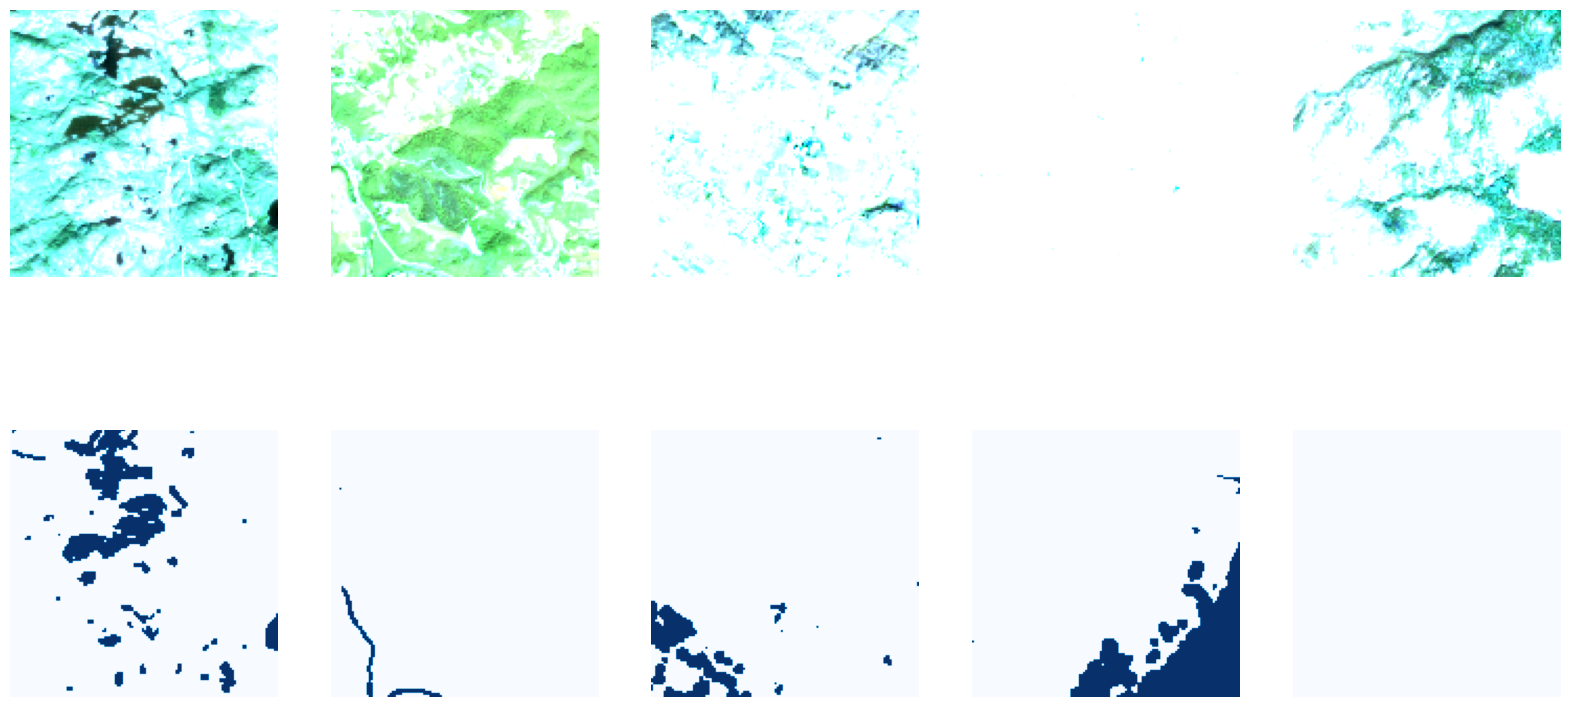

In [25]:
import matplotlib.pyplot as plt
import cmocean
# Select 5 images and masks
img_samples = images[:5]
mask_samples = labels[:5]
img_samples_normalized = img_samples / 255.0

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

# Display images and masks
for i in range(5):
    axs[0, i].imshow(img_samples_normalized[i],cmap=cmocean.cm.topo)
    axs[0, i].axis('off')
    axs[1, i].imshow(mask_samples[i], cmap='Blues')
    axs[1, i].axis('off')

plt.show()

In [26]:
def augment_images_with_labels(images, labels, num_augmented_per_image=5):

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
    )

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):

        img = np.expand_dims(img, 0)
        label = np.expand_dims(label, 0)

        seed = np.random.randint(1e6)

        img_gen = datagen.flow(img, batch_size=1, seed=seed)
        label_gen = datagen.flow(np.expand_dims(label, axis=-1), batch_size=1, seed=seed)

        for _ in range(num_augmented_per_image):
            augmented_img = next(img_gen)[0]
            augmented_label = next(label_gen)[0].squeeze(-1)

            augmented_images.append(augmented_img)
            augmented_labels.append(augmented_label)

    all_images = np.concatenate((images, np.array(augmented_images)), axis=0)
    all_labels = np.concatenate((labels, np.array(augmented_labels)), axis=0)

    return all_images, all_labels

In [27]:
images, labels = augment_images_with_labels(images, labels)
images.shape, labels.shape

((1836, 128, 128, 3), (1836, 128, 128))

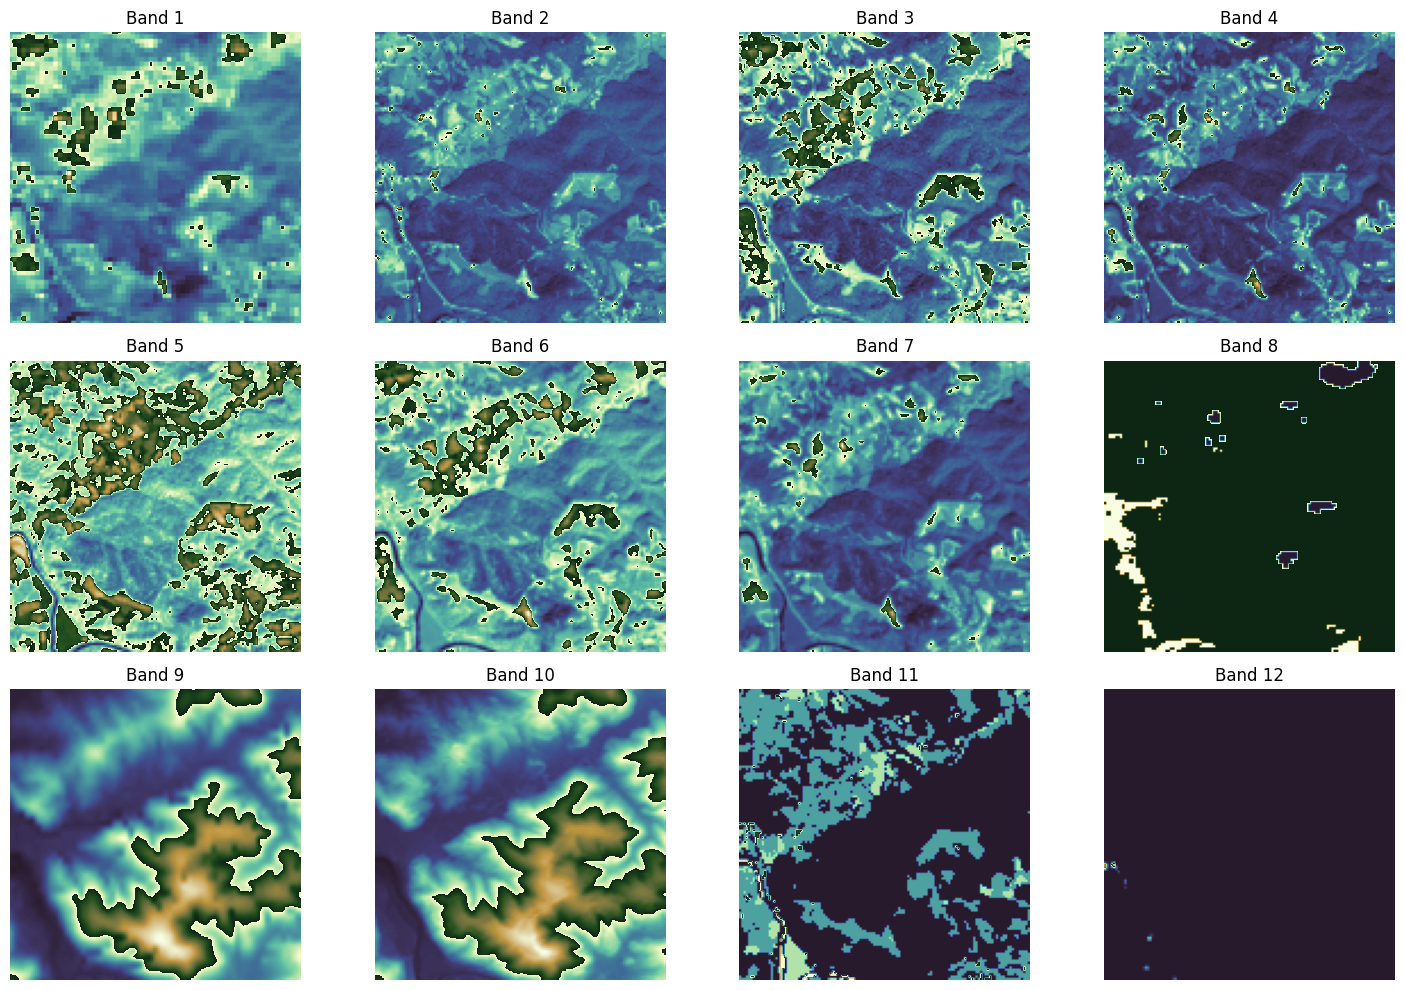

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import dask_image
import dask_image.imread

# Assume that X is the NumPy array containing the 12-channel images
# with shape (num_images, height, width, 12)

# Select a single image from the array
image = dask_image.imread.imread("/content/drive/MyDrive/Classroom/data/images/1.tif")

# Create a figure with 12 subplots
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Iterate over each band and visualize it
for i in range(12):
    band = image[0, :, :, i]  # Select a specific channel
    axs[i // 4, i % 4].imshow(band, cmap=cmocean.cm.topo)  # Use a more colorful colormap
    axs[i // 4, i % 4].set_title(f'Band {i+1}')
    axs[i // 4, i % 4].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

In [14]:
pip install dask_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 15.2 MB/s eta 0:00:00
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=99e4cdbe28a2f916f45349a495d1aac780640a00cb52734ce76ed65f6d807d3d
  Stored in directory: /root/.cache/pip/wheels/54/cb/f1/939f4adc0c5bcb1a1a78566d67869368d3d8dc8abd84f63c38
Successfully built pims


In [15]:
pip install cmocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 8.8 MB/s eta 0:00:00


In [29]:
X_train, X_test, y_train, Y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# building autoencoder model using MobilNet

In [30]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [31]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='best_model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [32]:
def encoder_model(inputs):
    base_model = applications.MobileNet(include_top=False, weights="imagenet", input_tensor=inputs)
    base_model.trainable = True
    return models.Model(inputs=base_model.input, outputs=base_model.get_layer('conv_pw_10_relu').output)

In [33]:
def decoder_model(encoder_output):
    x = encoder_output

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

    return x

def build_segmentation_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    encoder = encoder_model(inputs)
    x = encoder.output

    x = layers.Dropout(0.2)(x)  # Add dropout layer
    x = decoder_model(x)

    model = models.Model(inputs=inputs, outputs=x)

    # Compile the model with a suitable optimizer and loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [34]:
input_shape = (128, 128, 3)
model = build_segmentation_model(input_shape)

<ipython-input-32-08d5973f5692>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNet(include_top=False, weights="imagenet", input_tensor=inputs)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
model.compile(optimizer="adam", loss=dice_loss, metrics=["accuracy", dice_loss])
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[checkpoint_callback])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7092 - dice_loss: 0.4584 - loss: 0.4584
Epoch 1: val_accuracy improved from -inf to 0.61117, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 515ms/step - accuracy: 0.7113 - dice_loss: 0.4557 - loss: 0.4558 - val_accuracy: 0.6112 - val_dice_loss: 0.5006 - val_loss: 0.4952
Epoch 2/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8840 - dice_loss: 0.2072 - loss: 0.2072
Epoch 2: val_accuracy improved from 0.61117 to 0.81455, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8843 - dice_loss: 0.2068 - loss: 0.2068 - val_accuracy: 0.8146 - val_dice_loss: 0.3429 - val_loss: 0.3382
Epoch 3/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8976 - dice_loss: 0.1702 - loss: 0.1702
Epoch 3: val_accuracy improved from 0.81455 to 0.87239, saving model to best_model_weights.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8978 

# visualize model results

In [36]:
model.evaluate(X_test,y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - accuracy: 0.9265 - dice_loss: 0.1042 - loss: 0.1041


[0.11105267703533173, 0.9241403937339783, 0.11166834831237793]

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step


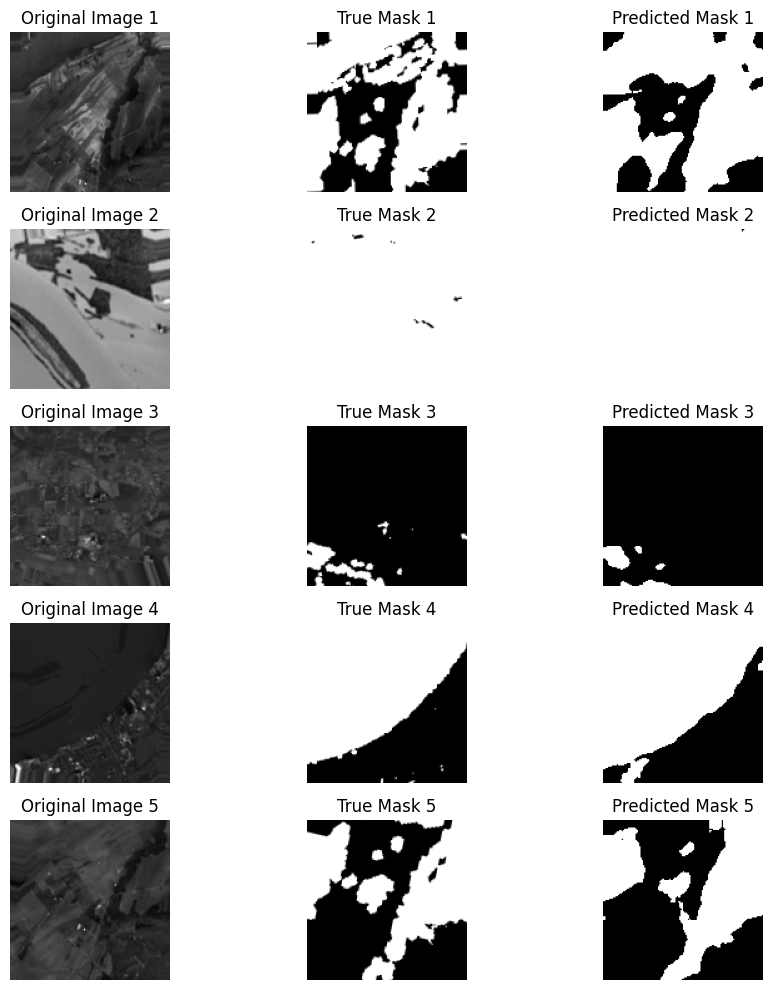

In [37]:
def show_image_mask_prediction(original_images, true_masks, predicted_masks, num_images=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i][:, :, 0], cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i], cmap='gray')
        plt.title(f"True Mask {i+1}")
        plt.axis('off')


        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(np.where(predicted_masks[i]>0.5, 1, 0), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_image_mask_prediction(X_test[18:], y_test[18:], model.predict(X_test[18:]), num_images=5)